In [1]:
!pip install datasets torch --quiet

In [2]:
# Mini Mamba vs Transformer: small illustrative next-token prediction example
# Paste into Colab (single cell) or run as a script.
# Tested on PyTorch 2.x / Python 3.9+. Small sizes for demo.

import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
import numpy as np
import random
import time
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


## Load WikiText Data

In [3]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:1%]")  # tiny subset for demo
text = "\n".join(dataset["text"]).lower()
chars = sorted(list(set(text)))
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}

SEQ_LEN = 32
vocab_size = len(stoi)

# Encode text into integers
data = torch.tensor([stoi[c] for c in text], dtype=torch.long)

def create_sequences(data, seq_len):
  X, Y = [], []
  for i in range(0, len(data)-seq_len):
    X.append(data[i:i+seq_len])
    Y.append(data[i+seq_len])
  return torch.stack(X), torch.stack(Y)

X, Y = create_sequences(data, SEQ_LEN)
train_size = int(0.9*len(X))
train_X, val_X = X[:train_size], X[train_size:]
train_Y, val_Y = Y[:train_size], Y[train_size:]

train_loader = DataLoader(TensorDataset(train_X, train_Y), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(val_X, val_Y), batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Models

In [4]:
class SSMLayer(nn.Module):
  def __init__(self, n_state, n_in, vocab_size):
    super().__init__()
    self.n_state = n_state
    self.A = nn.Parameter(torch.randn(n_state, n_state) * 0.1)
    self.B = nn.Parameter(torch.randn(n_state, n_in) * 0.1)
    self.C = nn.Parameter(torch.randn(vocab_size, n_state) * 0.1)
    self.D = nn.Parameter(torch.randn(vocab_size, n_in) * 0.1)
    self.state_norm = nn.LayerNorm(n_state)

  def forward(self, u_emb):
    B, T, n_in = u_emb.shape
    x = torch.zeros(B, self.n_state, device=u_emb.device)
    logits = []
    for t in range(T):
      u_t = u_emb[:, t, :]
      x = torch.tanh(x @ self.A.T + u_t @ self.B.T)
      x = self.state_norm(x)
      y_t = x @ self.C.T + u_t @ self.D.T
      logits.append(y_t)
    return torch.stack(logits, dim=1)

class TinyMamba(nn.Module):
  def __init__(self, vocab_size, n_embed=128, n_state=128):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, n_embed)
    self.ssm = SSMLayer(n_state, n_embed, vocab_size)

  def forward(self, x):
    emb = self.embed(x)
    logits = self.ssm(emb)
    return logits  # [B, T, vocab_size]


In [5]:
class TinyTransformer(nn.Module):
  def __init__(self, vocab_size, n_embed=128, n_head=4, n_layers=2, ff=256, dropout=0.1):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, n_embed)
    self.pos_emb = nn.Parameter(torch.randn(SEQ_LEN, n_embed) * 0.01)
    encoder_layer = nn.TransformerEncoderLayer(d_model=n_embed, nhead=n_head, dim_feedforward=ff, dropout=dropout)
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
    self.readout = nn.Linear(n_embed, vocab_size)

  def forward(self, x):
    B, T = x.shape
    xemb = self.embed(x) + self.pos_emb[:T, :].unsqueeze(0)
    xemb = xemb.permute(1,0,2)  # [T, B, embed]
    out = self.transformer(xemb)
    out = out.permute(1,0,2)     # [B, T, embed]
    last = out[:, -1, :]
    logits = self.readout(last)
    return logits  # only last token

## Training

In [6]:
def train_model(model, loader, val_loader, epochs=3, lr=1e-3, is_transformer=False):
  model = model.to(device)
  opt = torch.optim.Adam(model.parameters(), lr=lr)
  loss_fn = nn.CrossEntropyLoss()
  history = {"train": [], "val": []}

  for epoch in range(epochs):
    t0 = time.time()
    model.train()
    total_loss = 0
    for xb, yb in loader:
      xb, yb = xb.to(device), yb.to(device)
      opt.zero_grad()
      logits = model(xb)
      if not is_transformer:
        logits = logits[:, -1, :]  # use last timestep for comparison
      loss = loss_fn(logits, yb)
      loss.backward()
      opt.step()
      total_loss += loss.item()
    avg_train = total_loss / len(loader)

    # Validation
    model.eval()
    total_val = 0
    with torch.no_grad():
      for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        if not is_transformer:
          logits = logits[:, -1, :]
        loss = loss_fn(logits, yb)
        total_val += loss.item()
    avg_val = total_val / len(val_loader)

    history["train"].append(avg_train)
    history["val"].append(avg_val)
    print(f"Epoch {epoch+1}: train_loss={avg_train:.4f}, val_loss={avg_val:.4f}, time taken={time.time() - t0:.4f}s")
  return history

In [7]:
mamba = TinyMamba(vocab_size=vocab_size, n_embed=64, n_state=64)
trans = TinyTransformer(vocab_size=vocab_size, n_embed=64)

print("Training Mamba...")
hist_mamba = train_model(mamba, train_loader, val_loader, epochs=10, is_transformer=False)
print("\nTraining Transformer...")
hist_trans = train_model(trans, train_loader, val_loader, epochs=10, is_transformer=True)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Training Mamba...
Epoch 1: train_loss=2.2565, val_loss=2.0158, time taken=62.5461s
Epoch 2: train_loss=1.9522, val_loss=1.9159, time taken=57.9498s
Epoch 3: train_loss=1.8545, val_loss=1.8710, time taken=66.2985s
Epoch 4: train_loss=1.7959, val_loss=1.8356, time taken=60.6710s
Epoch 5: train_loss=1.7549, val_loss=1.8296, time taken=60.6397s
Epoch 6: train_loss=1.7254, val_loss=1.8090, time taken=55.3717s
Epoch 7: train_loss=1.7010, val_loss=1.7845, time taken=55.0449s
Epoch 8: train_loss=1.6837, val_loss=1.7819, time taken=54.1752s
Epoch 9: train_loss=1.6670, val_loss=1.7571, time taken=55.4299s
Epoch 10: train_loss=1.6543, val_loss=1.7794, time taken=54.9178s

Training Transformer...
Epoch 1: train_loss=2.4196, val_loss=2.1047, time taken=117.1591s
Epoch 2: train_loss=2.0802, val_loss=1.9677, time taken=116.6384s
Epoch 3: train_loss=1.9576, val_loss=1.8951, time taken=119.0650s
Epoch 4: train_loss=1.8793, val_loss=1.8339, time taken=116.7467s
Epoch 5: train_loss=1.8310, val_loss=1.817

In [12]:
def print_model_summary(model, name="Model"):
  print(f"--- {name} ---")
  total_params = 0
  for n, p in model.named_parameters():
    if p.requires_grad:
      print(f"{n:40} {tuple(p.shape)}")
      total_params += p.numel()
  print(f"Total trainable parameters: {total_params}\n")

In [13]:
print_model_summary(mamba, "Tiny Mamba")
print_model_summary(trans, "Tiny Transformer")

--- Tiny Mamba ---
embed.weight                             (107, 64)
ssm.A                                    (64, 64)
ssm.B                                    (64, 64)
ssm.C                                    (107, 64)
ssm.D                                    (107, 64)
ssm.state_norm.weight                    (64,)
ssm.state_norm.bias                      (64,)
Total trainable parameters: 28864

--- Tiny Transformer ---
pos_emb                                  (32, 64)
embed.weight                             (107, 64)
transformer.layers.0.self_attn.in_proj_weight (192, 64)
transformer.layers.0.self_attn.in_proj_bias (192,)
transformer.layers.0.self_attn.out_proj.weight (64, 64)
transformer.layers.0.self_attn.out_proj.bias (64,)
transformer.layers.0.linear1.weight      (256, 64)
transformer.layers.0.linear1.bias        (256,)
transformer.layers.0.linear2.weight      (64, 256)
transformer.layers.0.linear2.bias        (64,)
transformer.layers.0.norm1.weight        (64,)
transformer.lay

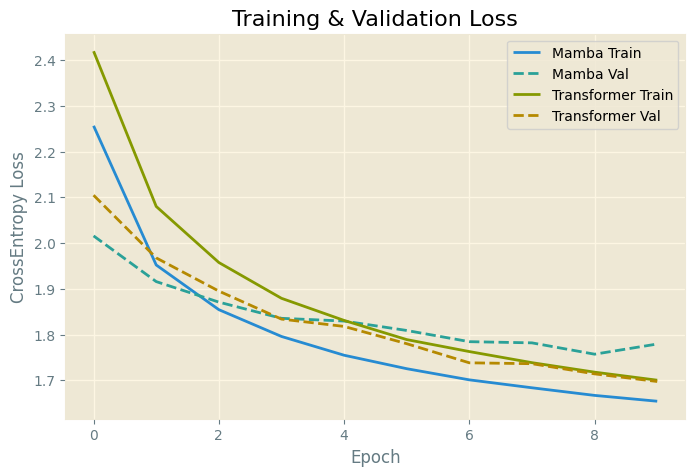

In [18]:
plt.style.use("Solarize_Light2")
fig, ax = plt.subplots(figsize=(8,5), facecolor="none")

plt.plot(hist_mamba["train"], label="Mamba Train")
plt.plot(hist_mamba["val"], label="Mamba Val", linestyle="--")
plt.plot(hist_trans["train"], label="Transformer Train")
plt.plot(hist_trans["val"], label="Transformer Val", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

## Comparing Outputs

In [22]:
def predict_next(model, prompt, stoi, itos, max_new_tokens=15, is_transformer=False, SEQ_LEN=32):
  model.eval()
  idx = torch.tensor([stoi.get(c,0) for c in prompt], dtype=torch.long, device=device).unsqueeze(0)
  generated = list(prompt)

  for _ in range(max_new_tokens):
    with torch.no_grad():
      # Keep only the last SEQ_LEN tokens for the Transformer
      inp = idx[:, -SEQ_LEN:] if is_transformer else idx
      logits = model(inp)
      if not is_transformer:
        logits = logits[:, -1, :]
      probs = torch.softmax(logits, dim=-1)
      next_id = torch.argmax(probs, dim=-1)[0].item()
    generated.append(itos[next_id])
    idx = torch.cat([idx, torch.tensor([[next_id]], device=device)], dim=1)

  return "".join(generated)


In [28]:
prompt = "control theory is a field of "
print("\nMamba prediction:")
print(predict_next(mamba, prompt, stoi, itos, max_new_tokens=50, is_transformer=False))
print("\nTransformer prediction:")
print(predict_next(trans, prompt, stoi, itos, max_new_tokens=50, is_transformer=True))


Mamba prediction:
control theory is a field of the season , the season , the season , the season 

Transformer prediction:
control theory is a field of team 's state the state the season , and the state


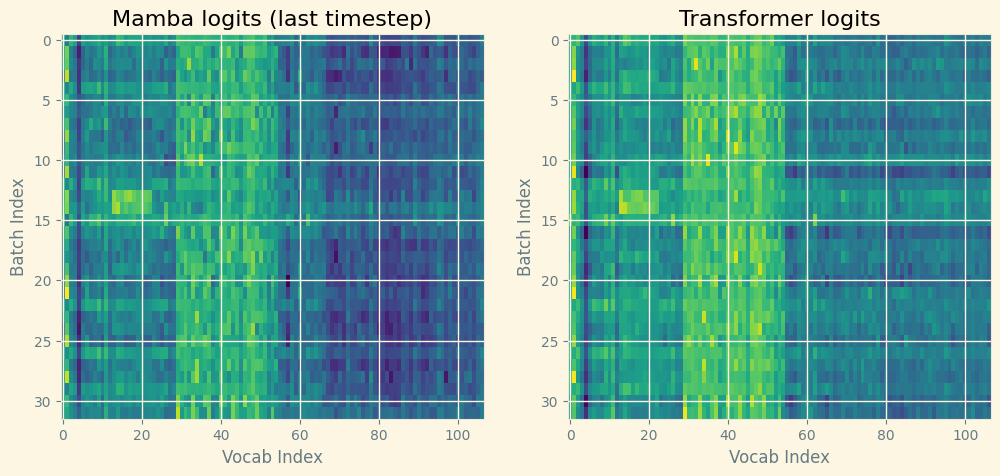

In [29]:
xb, yb = next(iter(val_loader))
xb = xb.to(device)
with torch.no_grad():
  logits_mamba = mamba(xb)[:, -1, :]
  logits_trans = trans(xb)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(logits_mamba.detach().cpu().numpy(), aspect='auto')
plt.xlabel("Vocab Index")
plt.ylabel("Batch Index")
plt.title("Mamba logits (last timestep)")

plt.subplot(1,2,2)
plt.imshow(logits_trans.detach().cpu().numpy(), aspect='auto')
plt.xlabel("Vocab Index")
plt.ylabel("Batch Index")
plt.title("Transformer logits")
plt.show()
